<a href="https://colab.research.google.com/github/XenoicZ/EPE/blob/main/Copy_of_GNN_ref.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
!git clone https://github.com/atlas-calo-ml/gn4pions_eastbay.git

Cloning into 'gn4pions_eastbay'...
remote: Enumerating objects: 1117, done.
remote: Counting objects: 100% (1117/1117), done.
remote: Compressing objects: 100% (427/427), done.
remote: Total 1117 (delta 677), reused 1116 (delta 676), pack-reused 0
Receiving objects: 100% (1117/1117), 208.98 MiB | 33.84 MiB/s, done.
Resolving deltas: 100% (677/677), done.


In [34]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [35]:
!cd gn4pions_eastbay
!pip install uproot
!pip install graph_nets
!pip install dm-sonnet
!pip install graphs
!pip install compress_pickle
!pip install PyYAML==5.1
!pip install atlas_mpl_style
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 302 kB 5.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76 kB 2.9 MB/s 
     |████████████████████████████████| 254 kB 10.7 MB/s 
  Created wheel for graph-nets: filename=graph_nets-1.1.0-py3-none-any.whl size=91857 sha256=a019b6ba0b6a4b264b7e6ba1050e378dd7989f66df7abc622b04ea8a27e28c7b
  Stored in directory: /root/.cache/pip/wheels/44/3d/65/f2e8f0a8d0b28bea5f168fc717261a67303d2183a3e450c812
Successfully built graph-nets
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 304 kB 5.1 MB/s 
  Created wheel for graphs: filename=graphs-0.1.3-cp37-cp37m-linux_x86_64.whl siz

In [36]:
%cd gn4pions_eastbay
import numpy as np
import os
import sys
import glob
import uproot as ur
import matplotlib
import matplotlib.pyplot as plt
import time
import seaborn as sns
import tensorflow as tf
from graph_nets import utils_np
from graph_nets import utils_tf
from graph_nets.graphs import GraphsTuple
import sonnet as snt
import argparse
import yaml
import logging
import tensorflow as tf
import gn4pions.modules.resolution_util as ru
import gn4pions.modules.plot_util as pu
import atlas_mpl_style as ampl
import importlib

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr, spearmanr
from gn4pions.modules.data import GraphDataGenerator
from gn4pions.modules.models import MultiOutWeightedRegressModel
from gn4pions.modules.utils import convert_to_tuple

/content/gn4pions_eastbay


In [37]:
# Loading model config
config_file = '/content/gn4pions_eastbay/gn4pions/configs/weightedRegress.yaml'
config = yaml.load(open(config_file), Loader=yaml.FullLoader)


# Data config
data_config = config['data']

data_dir = data_config['data_dir']
num_train_files = data_config['num_train_files']
num_val_files = data_config['num_val_files']
batch_size = data_config['batch_size']
shuffle = data_config['shuffle']
num_procs = data_config['num_procs']
preprocess = data_config['preprocess']
output_dir = '/content/drive/MyDrive/ml4pion/model'
already_preprocessed = data_config['already_preprocessed']  # Set to false when running training for first time


# Model Config
model_config = config['model']

concat_input = model_config['concat_input']


# Traning Config
train_config = config['training']

epochs = train_config['epochs']
learning_rate = train_config['learning_rate']
alpha = train_config['alpha']
os.environ['CUDA_VISIBLE_DEVICES'] = str(train_config['gpu'])
log_freq = train_config['log_freq']
save_dir = train_config['save_dir'] + config_file.replace('.yaml','').split('/')[-1] + '_' + time.strftime("%Y%m%d")

os.makedirs(save_dir, exist_ok=True)
yaml.dump(config, open(save_dir + '/config.yaml', 'w'))

In [38]:
# Read data and create data generators
data_dir_0 = '/content/drive/MyDrive/ml4pion/data/pion_files/pi0_files/'
data_dir_pm = '/content/drive/MyDrive/ml4pion/data/pion_files/pion_files/'
pi0_files = np.array(0)
pion_files = np.array(0)
for i in range(1,10):
  pi0_files = np.append(pi0_files, data_dir_0 + '0' + str(i+10) + '.npy')
  pion_files = np.append(pion_files, data_dir_pm + '00' + str(i) + '.npy' )

num_train_files = 6
num_val_files = 3
train_start = 0
train_end = train_start + num_train_files
val_end = train_end + num_val_files

pi0_train_files = pi0_files[train_start:train_end]
pi0_val_files = pi0_files[train_end:val_end]
pion_train_files = pion_files[train_start:train_end]
pion_val_files = pion_files[train_end:val_end]

train_output_dir = None
val_output_dir = None


already_preprocessed = False

# Get Data
if preprocess:
    train_output_dir = output_dir + '/train/'
    val_output_dir = output_dir + '/val/'

    if already_preprocessed:
        train_files = np.sort(glob.glob(train_output_dir+'*.p'))[:num_train_files]
        val_files = np.sort(glob.glob(val_output_dir+'*.p'))[:num_val_files]

        pi0_train_files = train_files
        pi0_val_files = val_files
        pion_train_files = None
        pion_val_files = None

        train_output_dir = None
        val_output_dir = None

# Traning Data Generator
# Will preprocess data if it doesnt find pickled files
data_gen_train = GraphDataGenerator(pi0_file_list=pi0_train_files,
                                    pion_file_list=pion_train_files,
                                    cellGeo_file='/content/drive/MyDrive/ml4pion/data/pion_files/cell_geo.root',
                                    batch_size=batch_size,
                                    shuffle=shuffle,
                                    num_procs=num_procs,
                                    preprocess=preprocess,
                                    output_dir=train_output_dir)

# Validation Data generator
# Will preprocess data if it doesnt find pickled files
data_gen_val = GraphDataGenerator(pi0_file_list=pi0_val_files,
                                  pion_file_list=pion_val_files,
                                  cellGeo_file='/content/drive/MyDrive/ml4pion/data/pion_files/cell_geo.root',
                                  batch_size=batch_size,
                                  shuffle=shuffle,
                                  num_procs=num_procs,
                                  preprocess=preprocess,
                                  output_dir=val_output_dir)



Preprocessing and saving data to /content/drive/MyDrive/ml4pion/model/train/
Processing file number 0


Process Process-1:


Processing file number 1


Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/content/gn4pions_eastbay/gn4pions/modules/data.py", line 258, in preprocessor
    event_data = np.load(file, allow_pickle=True).item()


Processing file number 2


  File "/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py", line 417, in load
    fid = stack.enter_context(open(os_fspath(file), "rb"))


Processing file number 3


FileNotFoundError: [Errno 2] No such file or directory: '0'


Processing file number 4
Processing file number 5
Finished processing 5 files
Finished processing 4 files
Finished processing 1 files
Finished processing 3 files
Finished processing 2 files

Preprocessing and saving data to /content/drive/MyDrive/ml4pion/model/val/
Processing file number 0
Processing file number 1
Processing file number 2
Finished processing 0 files
Finished processing 2 files
Finished processing 1 files


In [45]:
# Get batch of data
def get_batch(data_iter):
    for graphs, targets in data_iter:
        graphs = convert_to_tuple(graphs)
        targets = tf.convert_to_tensor(targets)
        yield graphs, targets
        
# Define loss function        
mae_loss = tf.keras.losses.MeanAbsoluteError()
#mae_loss = lambda y, p_y: -p_y.log_prob(y)
'''
def mae_loss(y, p_y):
  alpha, mu, sigma = slice_parameter_vectors(p_y)
  gm = tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(probs=alpha),
        components_distribution=tfd.Normal(loc=mu,scale=sigma) )
  log_likelihood = gm.log_prob(tf.transpose(y))
  return -tf.reduce_mean(log_likelihood, axis=-1)
'''

bce_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def loss_fn(targets, regress_preds, class_preds):
    regress_loss = mae_loss(targets[:,:1], regress_preds)
    class_loss = bce_loss(targets[:,1:], class_preds)
    combined_loss = alpha*regress_loss + (1 - alpha)*class_loss 
    return regress_loss, class_loss, combined_loss

In [40]:
# Get a sample graph for tf.function decorator
samp_graph, samp_target = next(get_batch(data_gen_train.generator()))
data_gen_train.kill_procs()
graph_spec = utils_tf.specs_from_graphs_tuple(samp_graph[0], True, True, True)

In [46]:
# Traning set
@tf.function(input_signature=[graph_spec, tf.TensorSpec(shape=[None,2], dtype=tf.float32)])
def train_step(graphs, targets):
    print('0')
    with tf.GradientTape() as tape:
        print('1')
        regress_output, class_output = model(graphs)
        print('2')
        regress_preds = regress_output.globals
        class_preds = class_output.globals
        regress_loss, class_loss, loss = loss_fn(targets, regress_preds, class_preds)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return regress_loss, class_loss, loss


# Validation Stepx
@tf.function(input_signature=[graph_spec, tf.TensorSpec(shape=[None,2], dtype=tf.float32)])
def val_step(graphs, targets):
    regress_output, class_output = model(graphs)
    regress_preds = regress_output.globals
    class_preds = class_output.globals
    regress_loss, class_loss, loss = loss_fn(targets, regress_preds, class_preds)
    return regress_loss, class_loss, loss, regress_preds, class_preds

In [47]:
# Model 
model = MultiOutWeightedRegressModel(global_output_size=1, num_outputs=2, model_config=model_config)
is_training_MDN = False

# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Average epoch losses
training_loss_epoch = []
training_loss_regress_epoch = []
training_loss_class_epoch = []
val_loss_epoch = []
val_loss_regress_epoch = []
val_loss_class_epoch = []

# Model checkpointing, load latest model if available
checkpoint = tf.train.Checkpoint(module=model)
checkpoint_prefix = os.path.join(save_dir, 'latest_model')
latest = tf.train.latest_checkpoint(save_dir)
if latest is not None:
    checkpoint.restore(latest)
else:
    checkpoint.save(checkpoint_prefix)

In [10]:
regress_output, class_output = model(samp_graph[0])
regress_preds = regress_output.globals
class_preds = class_output.globals


NameError: ignored

In [11]:
import importlib
gn4pions = importlib.reload(gn4pions)
gn4pions.modules.models = importlib.reload(gn4pions.modules.models)
gn4pions.modules.models_mdn = importlib.reload(gn4pions.modules.models_mdn)

NameError: ignored

In [42]:
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
import gn4pions
from gn4pions.modules.models import MultiOutWeightedRegressModel
from gn4pions.modules.models_mdn import MultiOutWeightedRegressModel_MDN
N_components = 3
model = MultiOutWeightedRegressModel_MDN(num_components=N_components, 
                                         global_output_size=1, num_outputs=2, 
                                         model_config=model_config)
is_training_MDN = True

checkpoint = tf.train.Checkpoint(module=model)
checkpoint_prefix = os.path.join(save_dir, 'latest_model')
latest = tf.train.latest_checkpoint(save_dir)
if latest is not None:
    checkpoint.restore(latest)
else:
    checkpoint.save(checkpoint_prefix)

def slice_parameter_vectors(parameter_vector):
    """ Returns an unpacked list of paramter vectors.
    """
    return [parameter_vector[:,i*N_components:(i+1)*N_components] for i in range(3)]

In [48]:
# Run training
curr_loss = 1e5
epochs = 1

for e in range(epochs):

    print(f'\n\nStarting epoch: {e}')
    epoch_start = time.time()
    
    # Batchwise losses
    training_loss = []
    training_loss_regress = []
    training_loss_class = []
    val_loss = []
    val_loss_regress = []
    val_loss_class = []

    
    # Train
    print('Training...')
    start = time.time()
    for i, (graph_data_tr, targets_tr) in enumerate(get_batch(data_gen_train.generator())):
        train_step(graph_data_tr[0], targets_tr)
        losses_tr_rg, losses_tr_cl, losses_tr = train_step(graph_data_tr[0], targets_tr)

        training_loss.append(losses_tr.numpy())
        training_loss_regress.append(losses_tr_rg.numpy())
        training_loss_class.append(losses_tr_cl.numpy())

        if not (i-1)%log_freq:
            end = time.time()
            print(f'Iter: {i:04d}, ', end='')
            print(f'Tr_loss_mean: {np.mean(training_loss):.4f}, ', end='')
            print(f'Tr_loss_rg_mean: {np.mean(training_loss_regress):.4f}, ', end='') 
            print(f'Tr_loss_cl_mean: {np.mean(training_loss_class):.4f}, ', end='') 
            print(f'Took {end-start:.4f}secs')
            start = time.time()
                  
        training_loss_epoch.append(training_loss)
        training_loss_regress_epoch.append(training_loss_regress)
        training_loss_class_epoch.append(training_loss_class)
        training_end = time.time()

        
    # validate
    print('\nValidation...')
    all_targets = []
    all_outputs = []
    start = time.time()
    for i, (graph_data_val, targets_val) in enumerate(get_batch(data_gen_val.generator())):
        losses_val_rg, losses_val_cl, losses_val, regress_vals, class_vals = val_step(graph_data_val[0], targets_val)

        targets_val = targets_val.numpy()
        regress_vals = regress_vals.numpy()
        class_vals = class_vals.numpy()

        targets_val[:,0] = 10**targets_val[:,0]
        regress_vals = 10**regress_vals
        class_vals =  tf.math.sigmoid(class_vals)

        output_vals = np.hstack([regress_vals, class_vals])

        val_loss.append(losses_val.numpy())
        val_loss_regress.append(losses_val_rg.numpy())
        val_loss_class.append(losses_val_cl.numpy())

        all_targets.append(targets_val)
        all_outputs.append(output_vals)

        if not (i-1)%log_freq:
            end = time.time()
            print(f'Iter: {i:04d}, ', end='')
            print(f'Val_loss_mean: {np.mean(val_loss):.4f}, ', end='')
            print(f'Val_loss_rg_mean: {np.mean(val_loss_regress):.4f}, ', end='') 
            print(f'Val_loss_cl_mean: {np.mean(val_loss_class):.4f}, ', end='') 
            print(f'Took {end-start:.4f}secs')
            start = time.time()

        epoch_end = time.time()

    print(f'Loss decreased from {curr_loss:.4f} to {np.mean(val_loss):.4f}')
    print(f'Checkpointing and saving predictions to:\n{save_dir}')
    curr_loss = np.mean(val_loss)
    np.savez('/content/drive/MyDrive/ml4pion/model/GNN_samp1', 
            targets=all_targets, 
            outputs=all_outputs)
    checkpoint.save(checkpoint_prefix)
    '''
    if np.mean(val_loss)<curr_loss:
        print(f'Loss decreased from {curr_loss:.4f} to {np.mean(val_loss):.4f}')
        print(f'Checkpointing and saving predictions to:\n{save_dir}')
        curr_loss = np.mean(val_loss)
        np.savez('/content/drive/MyDrive/ml4pion/model/GNN', 
                targets=all_targets, 
                outputs=all_outputs)
        checkpoint.save(checkpoint_prefix)
    else: 
        print(f'Loss didnt decrease from {curr_loss:.4f}')
    '''



Starting epoch: 0
Training...
0
1
2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/MultiOutWeightedRegressModel/core_3/graph_network/edge_block/broadcast_receiver_nodes_to_edges/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/MultiOutWeightedRegressModel/core_3/graph_network/edge_block/broadcast_receiver_nodes_to_edges/Reshape:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/MultiOutWeightedRegressModel/core_3/graph_network/edge_block/broadcast_receiver_nodes_to_edges/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/MultiOutWeightedRegressMod

0
1
2
Iter: 0001, Tr_loss_mean: 0.9566, Tr_loss_rg_mean: 1.1650, Tr_loss_cl_mean: 0.3316, Took 25.0011secs
Iter: 0101, Tr_loss_mean: 0.1566, Tr_loss_rg_mean: 0.1456, Tr_loss_cl_mean: 0.1894, Took 43.7632secs
Iter: 0201, Tr_loss_mean: 0.1167, Tr_loss_rg_mean: 0.1139, Tr_loss_cl_mean: 0.1250, Took 43.1903secs

Validation...
Iter: 0001, Val_loss_mean: 0.0629, Val_loss_rg_mean: 0.0707, Val_loss_cl_mean: 0.0394, Took 6.6005secs
Iter: 0101, Val_loss_mean: 0.0632, Val_loss_rg_mean: 0.0706, Val_loss_cl_mean: 0.0407, Took 13.4652secs
Loss decreased from 100000.0000 to 0.0630
Checkpointing and saving predictions to:
results/weightedRegress_20220731


/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:719: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


In [ ]:
predictions = np.load('/content/drive/MyDrive/ml4pion/model/GNN.npz', allow_pickle=True)
targets_regress = predictions['targets'][0][:, 0]
targets_class = predictions['targets'][0][:, 1]
outputs_regress = predictions['outputs'][0][:, 0]
outputs_class = predictions['outputs'][0][:, 1]

In [ ]:
predictions_MDN = np.load('/content/drive/MyDrive/ml4pion/model/GNN_samp1.npz', allow_pickle=True)
targets_regress_MDN = predictions_MDN['targets'][0][:, 0]
targets_class_MDN = predictions_MDN['targets'][0][:, 1]
outputs_regress_MDN = predictions_MDN['outputs'][0][:, 0]
outputs_class_MDN = predictions_MDN['outputs'][0][:, 1]

In [ ]:
def make_response_plot(y_true, y_pred, pion_label, f_name=''):
    y_ratio = y_pred/y_true

    p_r = pearsonr(y_true,y_pred)[0]
    s_r = spearmanr(y_true,y_pred)[0]
    mse = mean_squared_error(y_true,y_pred)
    mae = mean_absolute_error(y_true,y_pred)
    r2 = r2_score(y_true,y_pred)
    print("r2:{:.3f}".format(r2))
    print("PearsonR:{:.3f}, SpearmanR:{:.3f}, MSE:{:.3f}, MAE:{:.3f}".
          format(p_r, s_r, mse, mae))
    xcenter, medRegCNN = ru.responsePlot(y_true, y_ratio,
                                         figfile = f_name,
                                         statistic = 'median',
                                         atlas_x = 0.55, atlas_y = 0.95, simulation = True,
                                         
                                         textlist = [{'x': 0.55, 'y': 0.85, 'text': pion_label + ' GNN'}])
    return xcenter, medRegCNN


Plotting $\pi^{all}$
r2:0.986
PearsonR:0.994, SpearmanR:0.997, MSE:1.796, MAE:0.684


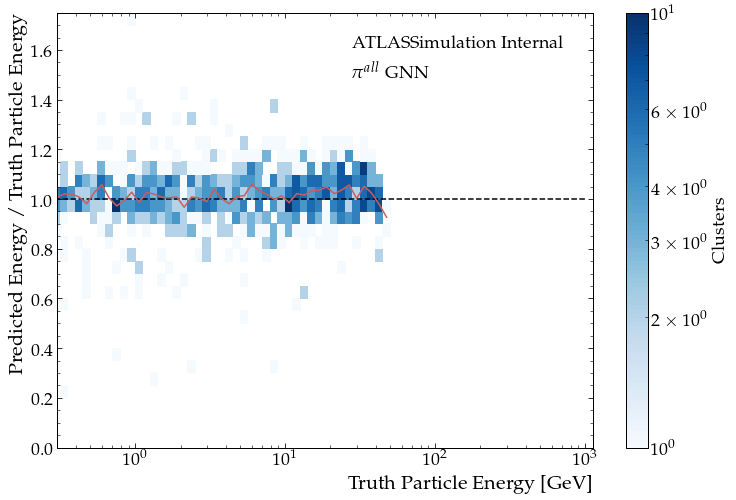


Plotting $\pi^{\pm}$


NameError: ignored

In [ ]:
c_map = sns.color_palette("Blues")

pion_list = ['$\pi^{all}$', '$\pi^{0}$', '$\pi^{\pm}$']
sym_list = ['', '0', '+-']
blues = matplotlib.cm.Blues_r(np.linspace(0,1,20))
oranges = matplotlib.cm.Oranges_r(np.linspace(0,1,20))

response_median_MDN = []

print('\nPlotting {}'.format(pion_list[0]))
y_true = targets_regress_MDN
y_pred = outputs_regress_MDN
xcenter, medRegCNN_MDN = make_response_plot(y_true, y_pred, pion_list[0])
#response_median.append(medRegCNN_MDN)
'''
print('\nPlotting {}'.format(pion_list[1]))
y_true = targets_regress[targets_class==0]
y_pred = outputs_regress[targets_class==0]
xcenter, medRegCNN = make_response_plot(y_true, y_pred, pion_list[1])
response_median.append(medRegCNN)
'''
print('\nPlotting {}'.format(pion_list[2]))
y_true = targets_regress_MDN[targets_class==1]
y_pred = outputs_regress_MDN[targets_class==1]
xcenter, medRegCNN_MDN = make_response_plot(y_true, y_pred, pion_list[2])
response_median_MDN.append(medRegCNN_MDN)

np.savez(data_dir+'/response_medians.npz', response_median=response_median, xcenter=xcenter)


Plotting $\pi^{all}$
r2:0.956
PearsonR:0.993, SpearmanR:0.997, MSE:6.372, MAE:1.401


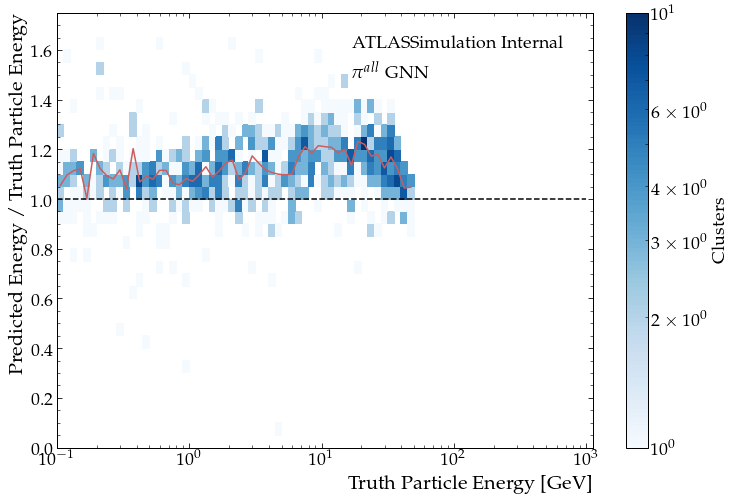


Plotting $\pi^{\pm}$
r2:0.956
PearsonR:0.993, SpearmanR:0.997, MSE:6.372, MAE:1.401


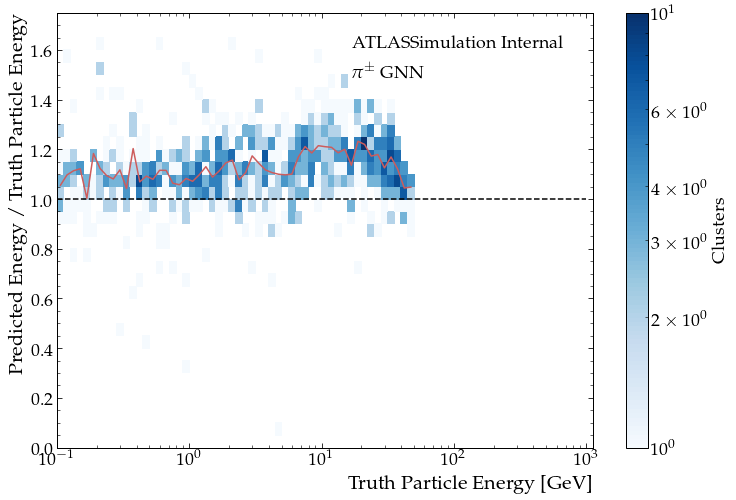

FileNotFoundError: ignored

In [ ]:
c_map = sns.color_palette("Blues")

pion_list = ['$\pi^{all}$', '$\pi^{0}$', '$\pi^{\pm}$']
sym_list = ['', '0', '+-']
blues = matplotlib.cm.Blues_r(np.linspace(0,1,20))
oranges = matplotlib.cm.Oranges_r(np.linspace(0,1,20))

response_median = []

print('\nPlotting {}'.format(pion_list[0]))
y_true = targets_regress
y_pred = outputs_regress
xcenter, medRegCNN = make_response_plot(y_true, y_pred, pion_list[0])
#response_median.append(medRegCNN)
'''
print('\nPlotting {}'.format(pion_list[1]))
y_true = targets_regress[targets_class==0]
y_pred = outputs_regress[targets_class==0]
xcenter, medRegCNN = make_response_plot(y_true, y_pred, pion_list[1])
response_median.append(medRegCNN)
'''
print('\nPlotting {}'.format(pion_list[2]))
y_true = targets_regress[targets_class==1]
y_pred = outputs_regress[targets_class==1]
xcenter, medRegCNN = make_response_plot(y_true, y_pred, pion_list[2])
response_median.append(medRegCNN)

np.savez(data_dir+'/response_medians.npz', response_median=response_median, xcenter=xcenter)

In [ ]:
response_median_MDN[0]

array([0.98042101, 1.02363849, 0.93978482, 0.96685016, 0.96342105,
       0.98699307, 0.97102892, 0.9083401 , 0.95533055, 0.98590672,
       0.90252244, 0.96683502, 0.9516753 , 0.97557873, 0.91176778,
       0.93717325, 0.85480005, 0.98173213, 0.96115118, 1.00749302,
       0.97028655, 0.9667778 , 0.9641484 , 1.06087375, 0.96581817,
       0.95656168, 1.01579452, 0.96490806, 1.02833939, 1.01023221,
       1.02143002, 0.96749091, 1.0353694 , 0.99462152, 1.00319242,
       0.97492987, 0.95344043, 1.01525033, 0.9997074 , 1.01124573,
       1.01030159, 1.01445401, 1.02301943, 1.08768034, 1.04967558,
       1.05702484, 1.07401192, 1.12833178, 1.07367778, 1.05096567,
       1.03833938, 1.02132881, 0.99953532, 0.97628063,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        

extra_line [[0, 10000.0], [1, 1]]
['paper:green', 'paper:red', 'paper:blue', 'paper:orange']


<Figure size 799.992x599.976 with 0 Axes>

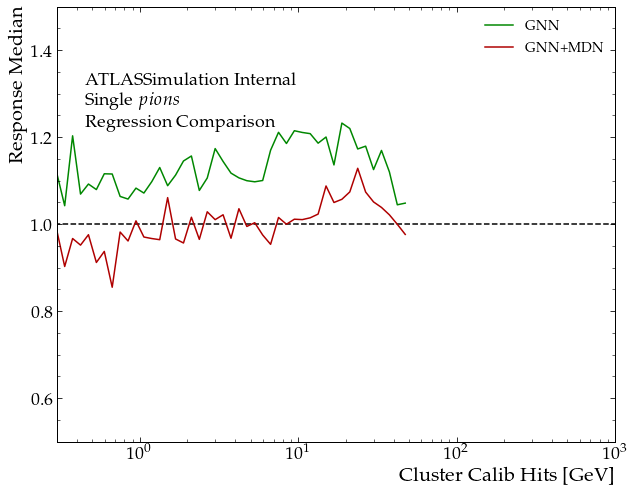

In [ ]:
pu.lineOverlay(xcenter=xcenter, lines=[response_median[0],response_median_MDN[0]],  # [iqrOverMedpi0, iqrOverMedpiplus, iqrOverMedpiminus],
                labels = ['GNN', 'GNN+MDN'],
                xlabel = 'Cluster Calib Hits [GeV]', ylabel = 'Response Median',
                figfile = '', # medResponse_gnBlock.png',
                y_max=1.5, y_min=.5, x_min = .3, colorgrouping=0,
                extra_lines= [[[0, 10e3], [1, 1]]],
                linestyles = ['solid', 'solid'], # , 'dashed',],
                atlas_x = 0.05, atlas_y = 0.85, simulation = True,
                textlist = [{'x': 0.05, 'y': 0.775, 'text': 'Single $pions$'},
                            {'x': 0.05, 'y': 0.725,  'text': 'Regression Comparison'}])

In [ ]:
def make_hist_plot(y_true, y_pred, pion_label, f_name=None, name=None):
    print('Wasserstein distance: {:.3f}'.format(wasserstein_distance(y_true, y_pred)))
    fig = plt.figure(figsize=(20,10))
    plt.hist(y_true, bins=np.linspace(-1., 4., 100), alpha=.5, label=r'$True$')
    plt.hist(y_pred, bins=np.linspace(-1., 4., 100), alpha=.5, label=r'$Predicted$')
    plt.legend(loc='upper right')
    plt.xlabel(r'$Log\ values$')
    plt.ylabel(r'$Counts$')
    plt.xlim([-1.5, 4.])

    atlas_x = 0.55 
    atlas_y = 0.95 
    simulation = True
    textlist = [{'x': 0.55, 'y': 0.88, 'text': pion_label + ' ' + name},
                {'x': 0.55, 'y': 0.83, 'text': 'Wasserstein distance: {:.4f}'.format(wasserstein_distance(y_true, y_pred))}]

    pu.drawLabels(fig, atlas_x, atlas_y, simulation, textlist)
    # sns.despine()
    if f_name:
        plt.savefig(f_name)
    plt.show()

In [ ]:
from scipy.stats import wasserstein_distance

In [ ]:
outputs_regress

array([ 2.3691678 ,  3.4755511 ,  0.09543721, ..., 20.859642  ,
        0.10005998,  6.845745  ], dtype=float32)


Plotting $\pi^{\pm}$
Wasserstein distance: 0.051


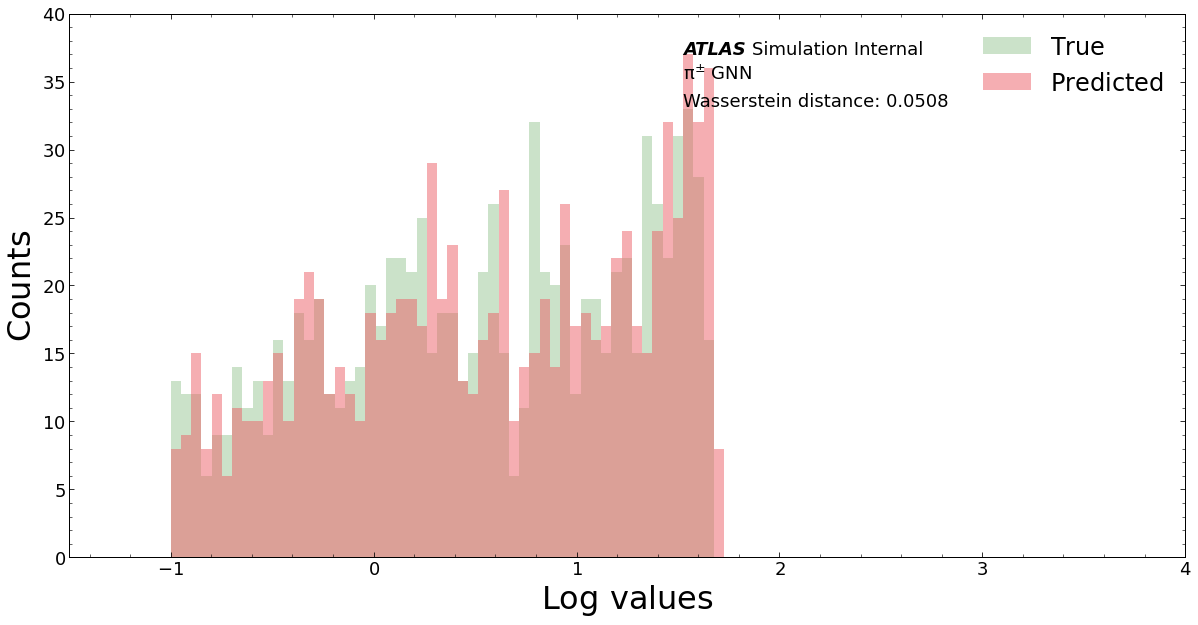

In [ ]:
import atlas_mpl_style as ampl
ampl.use_atlas_style()

# GNN histogram
# set plotsytle choices here
params = {'legend.fontsize': 24,
          'axes.labelsize': 32}
plt.rcParams.update(params)

ampl.set_color_cycle('Oceanic',10)

c_map = sns.color_palette("Blues")

pion_list = ['$\pi^{all}$', '$\pi^{0}$', '$\pi^{\pm}$']
blues = matplotlib.cm.Blues_r(np.linspace(0,1,20))
oranges = matplotlib.cm.Oranges_r(np.linspace(0,1,20))

#print('\nPlotting {}'.format(pion_list[0]))
#y_true = np.log10(targets_regress)
#y_pred = np.log10(outputs_regress)
#make_hist_plot(y_true, y_pred, pion_list[0])

#print('\nPlotting {}'.format(pion_list[1]))
#y_true = np.log10(targets_regress[targets_class==0])
#y_pred = np.log10(outputs_regress[targets_class==0])
#make_hist_plot(y_true, y_pred, pion_list[1])

print('\nPlotting {}'.format(pion_list[2]))
y_true = np.log10(targets_regress[targets_class==1])
y_pred = np.log10(outputs_regress[targets_class==1])
make_hist_plot(y_true, y_pred, pion_list[2], name='GNN')


Plotting $\pi^{\pm}$
Wasserstein distance: 0.018


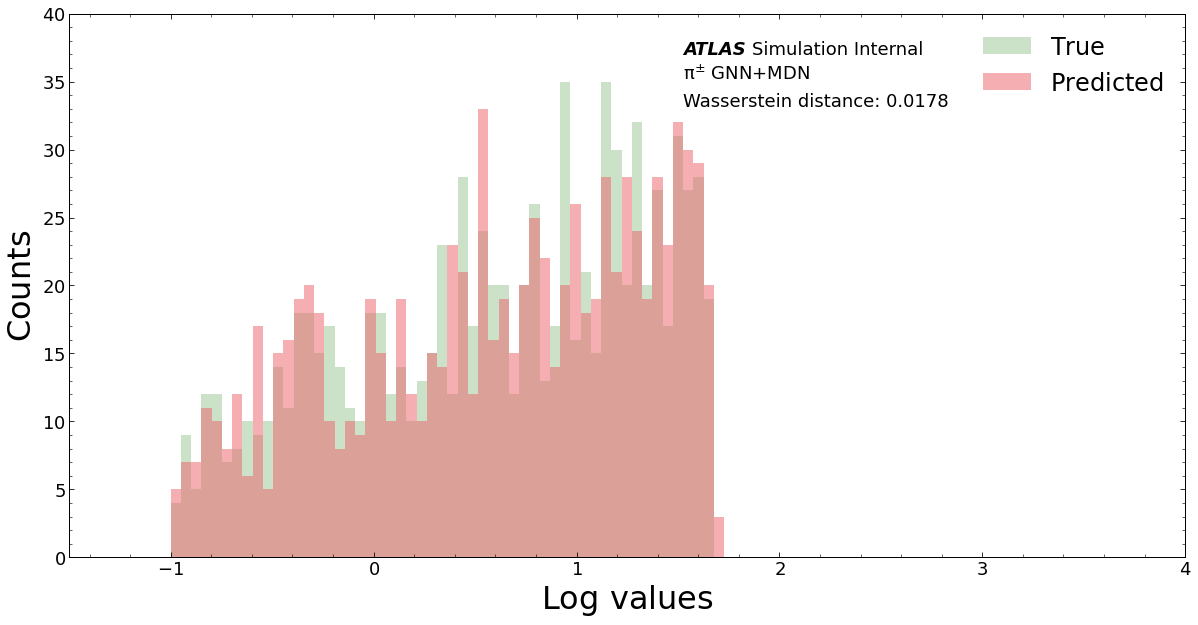

In [ ]:
print('\nPlotting {}'.format(pion_list[2]))
y_true_MDN = np.log10(targets_regress_MDN[targets_class==1])
y_pred_MDN = np.log10(outputs_regress_MDN[targets_class==1])
make_hist_plot(y_true_MDN, y_pred_MDN, pion_list[2], name='GNN+MDN')

In [ ]:
targets_regress

array([ 2.0128772 ,  3.040033  ,  0.08413535, ..., 23.456861  ,
        0.0831489 ,  6.221871  ], dtype=float32)


Plotting $\pi^{\pm}$ GNN


<Figure size 799.992x599.976 with 0 Axes>

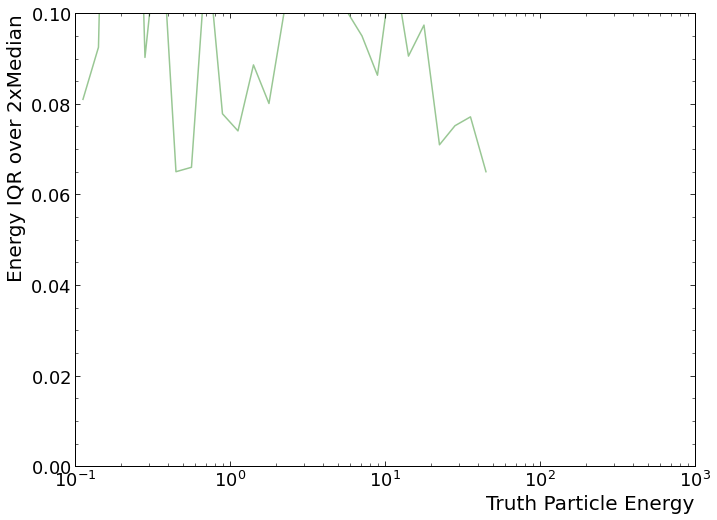


Plotting $\pi^{\pm}$ GNN+MDN


<Figure size 799.992x599.976 with 0 Axes>

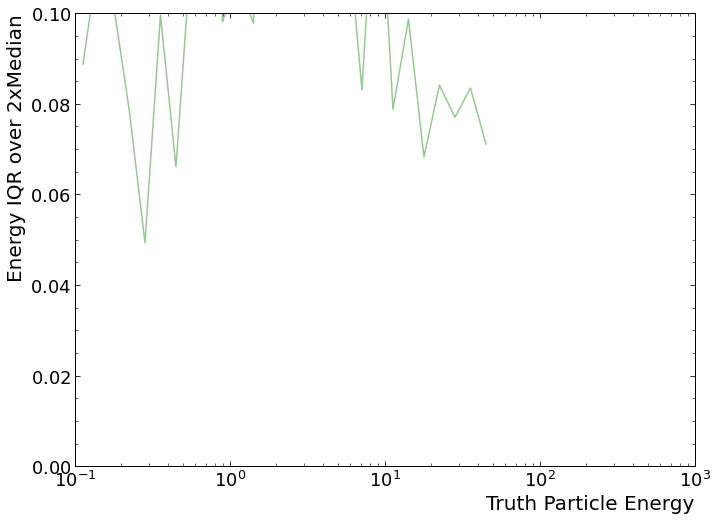

In [ ]:
iqr = []
iqr_MDN = []
#print('\nPlotting {}'.format(pion_list[0]))
#y_true = targets_regress
#y_pred = outputs_regress
#y_ratio = y_pred/y_true
#xcenter, iqr_curr= ru.resolutionPlot(y_true, y_ratio, statistic='iqrOverMed')
#iqr.append(iqr_curr)

#print('\nPlotting {}'.format(pion_list[1]))
#y_true = targets_regress[targets_class==0]
#y_pred = outputs_regress[targets_class==0]
#y_ratio = y_pred/y_true
#xcenter, iqr_curr= ru.resolutionPlot(y_true, y_ratio, statistic='iqrOverMed')
#iqr.append(iqr_curr)

print('\nPlotting {}'.format(pion_list[2]) + ' GNN')
y_true = targets_regress[targets_class==1]
y_pred = outputs_regress[targets_class==1]
y_ratio = y_pred/y_true
xcenter, iqr_curr= ru.resolutionPlot(y_true, y_ratio, statistic='iqrOverMed')
iqr.append(iqr_curr)

print('\nPlotting {}'.format(pion_list[2]) + ' GNN+MDN')
y_true_MDN = targets_regress_MDN[targets_class==1]
y_pred_MDN = outputs_regress_MDN[targets_class==1]
y_ratio_MDN = y_pred_MDN/y_true_MDN
xcenter, iqr_curr_MDN= ru.resolutionPlot(y_true_MDN, y_ratio_MDN, statistic='iqrOverMed')
iqr_MDN.append(iqr_curr_MDN)
#np.savez(data_dir+'/iqr.npz', response_median=iqr, xcenter=xcenter)

['on:green', 'on:red', 'on:blue', 'on:cyan', 'on:orange', 'on:pink', 'on:yellow']


<Figure size 799.992x599.976 with 0 Axes>

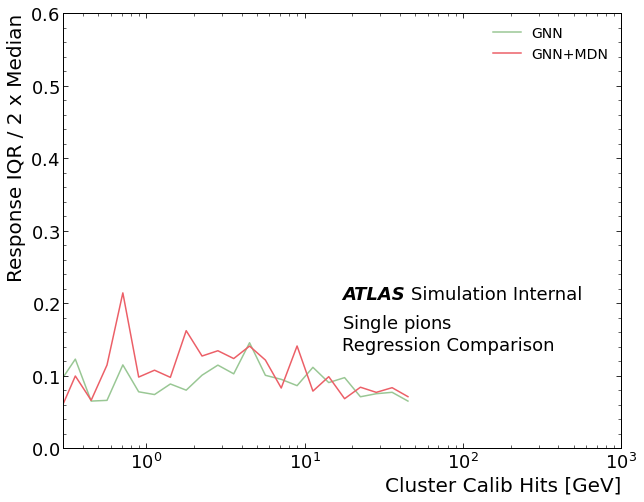

In [ ]:
pu.lineOverlay(xcenter=xcenter, lines = [iqr[0],iqr_MDN[0]],  # [iqrOverMedpi0, iqrOverMedpiplus, iqrOverMedpiminus],
                labels = ['GNN', 'GNN+MDN'],
                xlabel = 'Cluster Calib Hits [GeV]', ylabel = 'Response IQR / 2 x Median',
                figfile = '', # 'iqr_gnBlock.png',
                y_max = .6, x_min = .3,
                linestyles = ['solid', 'solid', 'solid'],  # , 'dashed',],
                atlas_x = 0.5, atlas_y = 0.375, simulation = True,
                textlist = [{'x': 0.5, 'y': 0.275, 'text': 'Single $pions$'},
                            {'x': 0.5, 'y': 0.225,  'text': 'Regression Comparison'}])

In [ ]:
data_dir

'/usr/workspace/hip/ML4Jets/regression_images/'

In [ ]:
pion_list = ['pion']
sym_list = ['+-',]
concat_type = ['False']
model_name = ['ConcatFalse']
line = ['-', '--', ':']
blues = matplotlib.cm.Blues_r(np.linspace(0,1,20))
oranges = matplotlib.cm.Oranges_r(np.linspace(0,1,20))

plt.figure(figsize=(15,7))
# print('\nPlotting losses fro {}'.format(data_dir))
hist_files = np.sort(glob.glob(data_dir + 'losses.npz'))
print('Loading form {}'.format(data_dir))


hist = np.load(hist_files[0])
plt.semilogy(hist['training'].mean(axis=1), color=blues[5, :3], 
             label=r'$Train$', linestyle=line[0])
plt.semilogy(hist['validation'].mean(axis=1), color=oranges[5, :3], 
             label=r'$Val$', linestyle=line[0])

plt.semilogy(hist['training_regress'].mean(axis=1), color=blues[5, :3], 
             label=r'$Train Regression$', linestyle=line[1])
plt.semilogy(hist['validation_regress'].mean(axis=1), color=oranges[5, :3], 
             label=r'$Val Regression$', linestyle=line[1])

plt.semilogy(hist['training_class'].mean(axis=1), color=blues[5, :3], 
             label=r'$Train Classification$', linestyle=line[2])
plt.semilogy(hist['validation_class'].mean(axis=1), color=oranges[5, :3], 
             label=r'$Val Classification$', linestyle=line[2])


plt.ylabel(r'$Loss$')
plt.xlabel(r'$Epochs$')
plt.ylim([5e-2, 5e-1])
# sns.despine()
plt.legend()
plt.savefig(data_dir+'/training_mse.png', bbox_inches='tight', dpi=300)
plt.show()

Loading form /usr/workspace/hip/ML4Jets/regression_images/


IndexError: ignored

<Figure size 1080x504 with 0 Axes>